# Figure 3
The aim here is to generate a set of true $(\kappa, s)$ parameters, then do ML estimation for both modified-Rachlin and Rachlin discount functions. We plot the true discount functions and the recovered parameter values.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib import gridspec
import numpy as np

%config InlineBackend.figure_format = 'retina'

import sys
print("Python version:\n{}\n".format(sys.version))

%run set_plot_options.py

from parameters import *
from discount_functions import rachlin, rachlin_kappa
from fitting import MLE_procedure
from model import get_response, calc_log_likelihood
from adaptive_experiment import make_dataset, plot_data

Python version:
3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]



Set the random seed, for reproducibility

In [2]:
np.random.seed(seed=34579)

## Down to business...
We are going to have multiple sets of true parameters, representing many simulated observers. We will run many experiments on them. They will produce slightly different datasets because of the stochastic nature of their responses. From this, we will get slightly different ML parameter estimates. We will plot the spread of these parameter estimates.

In [3]:
def MLE_inference(nll_func):
    """wrapper function for MLE"""
    bounds = [(0,3), (0,5)]
    fit = MLE_procedure(nll_func, bounds)
    if fit.success==False:
        print('Fit failed :(')
    return fit.x
    
    
def many_simulations(data_generating_params, N_simulations=500, debug=False):
    MLparams_Rachlin = np.empty([N_simulations, 2])
    MLparams_fixedRachlin = np.empty([N_simulations, 2])
    
    data_generating_discount_func = rachlin_kappa
    
    for i in range(N_simulations):
        data = make_dataset(data_generating_discount_func, data_generating_params)

        # create NLL functions to minimise, with the data embedded within them
        def nll_func_rachlin(params):
            return -calc_log_likelihood(data, rachlin, params)

        def nll_func_rachlin_kappa(params):
            return -calc_log_likelihood(data, rachlin_kappa, params)

        MLparams_Rachlin[i,:] = MLE_inference(nll_func_rachlin)
        MLparams_fixedRachlin[i,:] = MLE_inference(nll_func_rachlin_kappa)
    
    return (MLparams_Rachlin, MLparams_fixedRachlin, data_generating_params)

In [4]:
def make_kappa_s_parameter_grid(kappa_list, s_list):
    # kappa = cols, s = rows
    param_grid = np.zeros((len(s_list), len(kappa_list)), dtype=object)
    for row, s in enumerate(s_list):
        for col, kappa in enumerate(kappa_list):
            param_grid[row,col] = (s, kappa)
    return param_grid

# create parameter list
s_list = [0.2, 0.6, 1.0, 1.4, 1.8]
hl_list = np.logspace(1,2,4)
kappa_list = 1/hl_list

param_grid = make_kappa_s_parameter_grid(kappa_list, s_list)

## Create colours for each parameter combination
We want each column (value of $\kappa$) to take on a fixed hue, and for each value of $s$ to take on a different saturation.

In [5]:
# create a corresponding set of colours, one for each parameter combination

hue_list = np.linspace(0, 1, len(kappa_list)+1)
hue_list = hue_list[:-1]  # remove last element

saturation_list = np.linspace(0.2, 1, len(s_list))

cols = np.zeros((len(s_list), len(kappa_list)), dtype=object)
for row, saturation in enumerate(saturation_list):
    for col, hue in enumerate(hue_list):
        cols[row,col] = hsv_to_rgb((hue, saturation, 1)) 

# get list of hues (for each kappa) for the histograms
hue_cols = cols[-1,:]

## Run many simulations for all of the parameter combinations. 
**NOTE: This takes some time!**

In [6]:
results = np.zeros((len(s_list), len(kappa_list)), dtype=object)
for row, s in enumerate(s_list):
    for col, kappa in enumerate(kappa_list):
        params = param_grid[row,col]
        results[row,col] = many_simulations(params, N_simulations=30)

Now we have `results` which is a 2D array of tuples which contains lists.

## Plotting

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

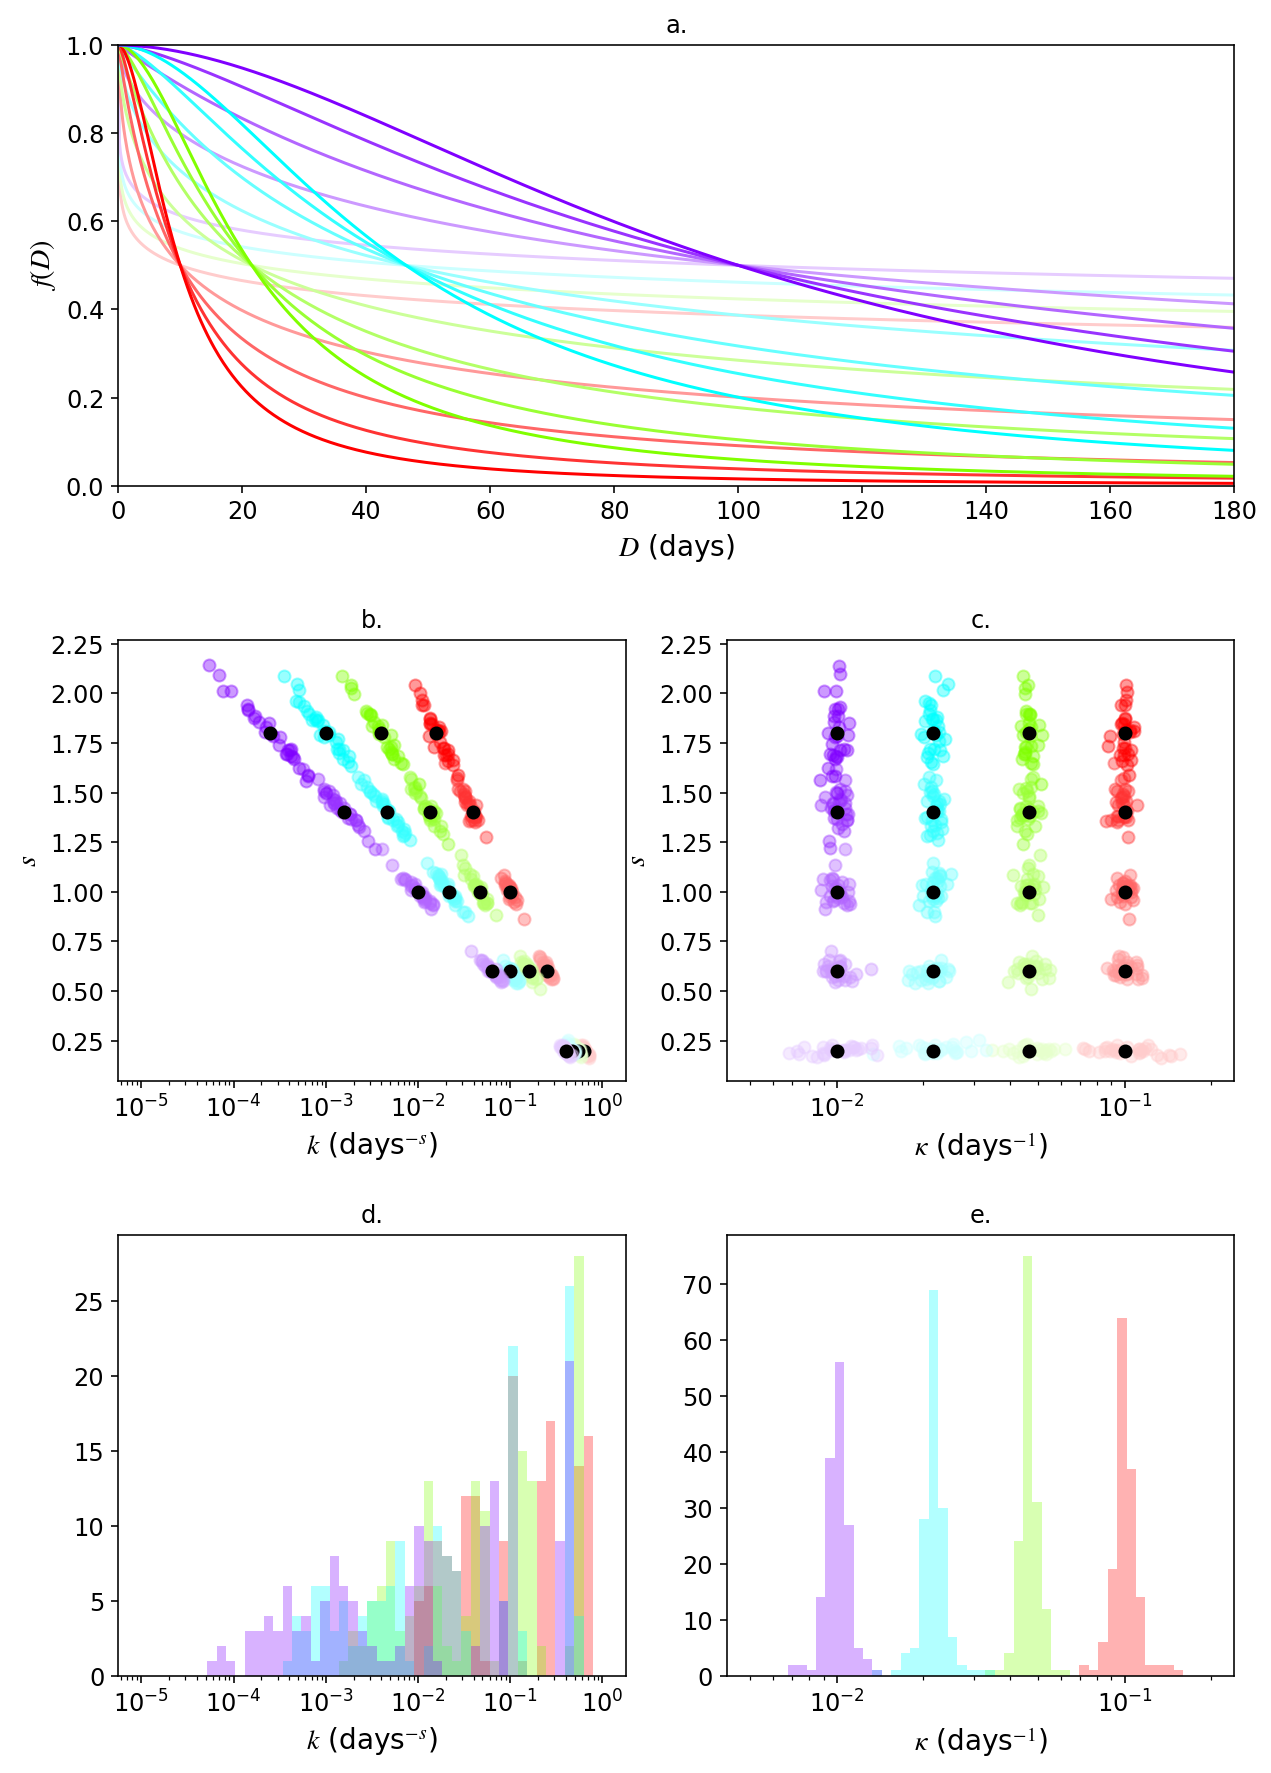

In [8]:
fig1 = plt.figure(figsize=(FIG_WIDTH_INCHES, FIG_WIDTH_INCHES*1.5))
subplot_size = (3,2)


# PLOT TRUE DISCOUNT FUNCTIONS =======================================================
MAX_DELAY = 180
axtop = plt.subplot2grid(subplot_size, (0, 0), colspan=2)
delays = np.linspace(0, MAX_DELAY, 1000)

for row, s in enumerate(s_list):
    for col, kappa in enumerate(kappa_list):
        params = param_grid[row,col]
        axtop.plot(delays, rachlin_kappa(delays, param_grid[row,col]), c=cols[row,col])
        
axtop.set_xlim([0, MAX_DELAY])
axtop.set_ylim([0, 1])
axtop.set_xlabel(r'$D$ (days)')
axtop.set_ylabel(r'$f(D)$')
axtop.set_title('a.')


# PLOT TRUE & RECOVERED PARAMETER VALUES =============================================
ax0 = plt.subplot2grid(subplot_size, (1, 0))
ax1 = plt.subplot2grid(subplot_size, (1, 1), sharey=ax0)

#for result, col in zip(results, cols):
for row, s in enumerate(s_list):
    for col, kappa in enumerate(kappa_list):
        
        rachlinθ, modified_rachlinθ, trueθ = results[row, col]

        s, kappa = trueθ
        k = kappa**s

        # plot MLE values for Rachlin
        ax0.scatter(x=rachlinθ[:,1], y=rachlinθ[:,0], c=cols[row,col], alpha=0.4)  # MLE
        ax0.scatter(x=k, y=s, c='k', label='true')  # plot true values
        ax0.set_xlabel(r'$k$ (days$^{-s}$)')
        ax0.set_ylabel(r'$s$')
        ax0.set_xscale("log")

        # plot MLE values for modified Rachlin
        ax1.scatter(x=modified_rachlinθ[:,1], y=modified_rachlinθ[:,0], c=cols[row,col], alpha=0.4)  # MLE
        ax1.scatter(x=kappa, y=s, c='k', label='true')  # plot true values
        ax1.set_xlabel(r'$\kappa$ (days$^{-1}$)')
        ax1.set_ylabel(r'$s$')
        ax1.set_xscale("log")
    
ax0.set_title('b.')
ax1.set_title('c.')


# HISTOGRAMS ========================================================================

ax2 = plt.subplot2grid(subplot_size, (2, 0), sharex=ax0)
ax2.set_xlabel(r'$k$ (days$^{-s}$)')

ax3 = plt.subplot2grid(subplot_size, (2, 1), sharex=ax1)
ax3.set_xlabel(r'$\kappa$ (days$^{-1}$)')

def get_R_vals(row, col):
    rachlinθ, modified_rachlinθ, trueθ = results[row,col]
    return rachlinθ[:,1]

def get_MR_vals(row, col):
    rachlinθ, modified_rachlinθ, trueθ = results[row,col]
    return modified_rachlinθ[:,1]

for col, kappa in enumerate(kappa_list):
  
    all_rachlin_values  = np.concatenate([get_R_vals(row, col) for row, _ in enumerate(s_list)])
    all_modified_rachlin_values  = np.concatenate([get_MR_vals(row, col) for row, _ in enumerate(s_list)])
    
    ax2.hist(all_rachlin_values, 
             alpha=0.3,
             bins=np.logspace(np.log10(0.00001),np.log10(1.0), 50),
             color=hue_cols[col])
    
    ax3.hist(all_modified_rachlin_values, 
             alpha=0.3, 
             bins=np.logspace(np.log10(0.005),np.log10(0.2), 50),
             color=hue_cols[col])
    
ax2.set_title('d.')
ax3.set_title('e.')


# FINISHING OFF =====================================================================
# adjust to avoid overlap in x-axis labels and figure titles
plt.subplots_adjust(hspace=0.35)

fig1.savefig("Figure3.pdf", bbox_inches='tight', dpi=300)